# Adding milk to the coffee

In [ ]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    # url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    url = "https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/"
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

In [2]:
def make_system(T_init, volume, r, t_end, T_env=22, t_0=0, dt=1):
    return modsim.System(
        T_init=T_init,
        T_final=T_init,
        volume=volume,
        r=r,
        t_end=t_end,
        T_env=T_env,
        t_0=t_0,
        dt=dt,
)

In [7]:
def change_func(t, T, system):
    r, T_env, dt = system.r, system.T_env, system.dt    
    return -r * (T - T_env) * dt

In [8]:
def run_simulation(system, change_func):
    t_array = modsim.linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    
    series = modsim.TimeSeries(index=t_array)
    series.iloc[0] = system.T_init
    
    for i in range(n - 1):
        t = t_array[i]
        T = series.iloc[i]
        series.iloc[i+1] = T + change_func(t, T, system)
    
    system.T_final = series.iloc[-1]
    return series

In [4]:
# Assuming coffee and milk with the same density and specific heat
def mix(system1, system2):
    
    V1, V2 = system1.volume, system2.volume
    T1, T2 = system1.T_final, system2.T_final
    
    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix
    
    return make_system(T_init=T_mix,
                       volume=V_mix,
                       r=system1.r,
                       t_end=30)

### Mix First or Last?

In [5]:
r_coffee = 0.0115
coffee = make_system(T_init=90, volume=300, r=r_coffee, t_end=30)

In [6]:
r_milk = 0.133
milk = make_system(T_init=5, volume=50, r=r_milk, t_end=15)

In [9]:
mix_first = mix(coffee, milk)
run_simulation(mix_first, change_func)

mix_first.T_final

61.48016207445017

In [10]:
run_simulation(coffee, change_func)
run_simulation(milk, change_func)
mix_last = mix(coffee, milk)
mix_last.T_final

62.91117032872072

### Optimal Timing

In [12]:
def run_and_mix(t_add, t_total):
    coffee.t_end = t_add
    coffee_results = run_simulation(coffee, change_func)
    
    milk.t_end = t_add
    milk_results = run_simulation(milk, change_func)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add # When t_add is 0, we add the milk immediately; when t_add is 30, we add it at the end
    results = run_simulation(mixture, change_func)

    return mixture.T_final

In [13]:
sweep = modsim.SweepSeries()
for t_add in numpy.linspace(0, 30, 11):
    sweep[t_add] = run_and_mix(t_add, 30)

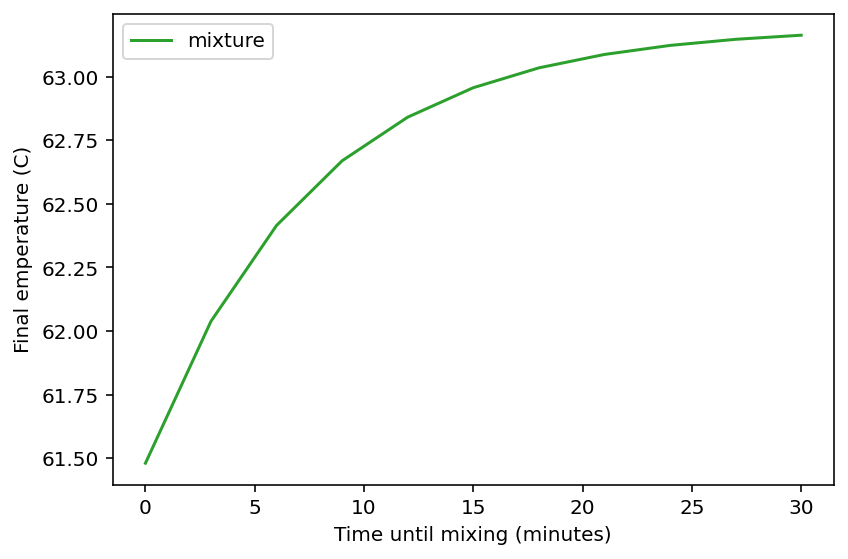

In [14]:
sweep.plot(label='mixture', color='C2')

modsim.decorate(xlabel='Time until mixing (minutes)',
         ylabel='Final emperature (C)')

### Analytic Solution

In [23]:
def compute_r(system):
    t_end = system.t_end
    T_init = system.T_init
    T_final = system.T_final
    T_env = system.T_env
    
    r = numpy.log(numpy.abs((T_init - T_env) / (T_final - T_env))) / t_end
    return r

In [24]:
coffee2 = make_system(T_init=90, volume=300, r=0, t_end=30)
coffee2.T_final = 70
r_coffee2 = compute_r(coffee2)
r_coffee2

0.01161022314227386

In [25]:
def run_analysis(system):
    T_env, T_init, r = system.T_env, system.T_init, system.r
    
    t_array = modsim.linrange(system.t_0, system.t_end, system.dt)    
    T_array = T_env + (T_init - T_env) * numpy.exp(-r * t_array)
    
    system.T_final = T_array[-1]
    return modsim.make_series(t_array, T_array)

In [26]:
coffee2.r = r_coffee2
results2 = run_analysis(coffee2)
coffee2.T_final

70.0

### Exercise 1
Use `compute_r` to compute `r_milk` according to the analytic solution. Run the analysis with this value of `r_milk` and confirm that the results are consistent with the simulation.

In [31]:
milk2 = make_system(T_init=5, volume=50, r=0, t_end=15)
milk2.T_final = 20
r_milk2 = compute_r(milk2)
r_milk2

0.14267107756641806

In [32]:
milk2.r = r_milk2
results2_milk = run_analysis(milk2)
milk2.T_final

20.0

### Exercise 2
Suppose the coffee shop won’t let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office. In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

Hint: Think about the simplest way to represent the behavior of a refrigerator in this model. The change you make to test this variation of the problem should be very small!

```
A refrigerator keeps the milk at a constant temperature,
so it is like a container with r = 0.

With T_init=5 and r_milk = 0, 
it is best to add the milk at the beginning.
```

In [41]:
r_coffee = 0.0115
coffee = make_system(T_init=90, volume=300, r=r_coffee, t_end=30)
r_milk = 0.133
milk = make_system(T_init=5, volume=50, r=r_milk, t_end=15)
mix_first = mix(coffee, milk)
run_simulation(mix_first, change_func)


run_simulation(coffee, change_func)
run_simulation(milk, change_func)
mix_last = mix(coffee, milk)
print("Milk added at the beggining in the store: ", mix_first.T_final, "C")
print("Milk added at 15 min: ", mix_last.T_final, "C")

Milk added at the beggining in the store:  61.48016207445017 C
Milk added at 15 min:  62.91117032872072 C


In [42]:
r_coffee = 0.0115
coffee = make_system(T_init=90, volume=300, r=r_coffee, t_end=30)
milk = make_system(T_init=5, volume=50, r=0, t_end=30)
mix_last = mix(coffee, milk)
print("Milk added at the end from the fridge: ", mix_last.T_final, "C")

Milk added at the end from the fridge:  77.85714285714286 C
